# ENUNCIADO
Somos trabajadores de una financiera de consumo de uno de los cinco bancos más grandes de España. Desde el departamento de operaciones nos informan de que están teniendo problemas con las tarjetas de crédito. Muchas tarjetas están siendo duplicadas y hay una gran cantidad de transferencias fraudulentas que se están cometiendo. Para resolver este hecho preguntan si podemos ayudarles con algún modelo estadístico.

Uno de los problemas en la financiación al consumo es el fraude en tarjetas, dinero que es cargado a los clientes por productos que ellos no han adquirido. Esto es un problema importante para el sector financiero, ya que, además de las pérdidas monetarias, disminuye la fidelización de los clientes. Hay que recordar que el sistema monetario actual se basa en la confianza, y el dinero es lo primero que escapa cuando no hay confianza en las entidades.

# CONTEXTO
En un escenario del mundo real, los algoritmos no supervisados se utilizan en estos casos para filtrar del total de transacciones cuáles son anómalas. A veces se utilizan reglas de negocio para hacer ese filtrado, pero muchas veces esas reglas son muy difíciles de formular. Ya que no es viable analizar todas las transacciones, un modelo no supervisado que filtre comportamientos extraños es muy útil para realizar una primera criba. Para ello se hallan características de cada transacción (X) y con detectores de anomalías se estima cuáles son anómalas y cuáles no.

Posteriormente, se auditan todas esas transacciones anómalas y se obtienen las etiquetas reales (Y). Se halla qué transacciones son fraudulentas (Y=1) y cuáles no (Y=0).

Llegado un punto, la entidad financiera tiene datos etiquetados (X,Y) que puede utilizar para realizar un clasificador de aprendizaje supervisado.

# PLANTEAMIENTO DEL PROBLEMA
En este caso se tienen las características de cada transacción (X) y la etiqueta indicando si son fraude o no (Y). Se podría realizar directamente un clasificador de aprendizaje supervisado, pero el objetivo es tener una aproximación a cómo de útil puede ser un modelo de detección de anomalías en pasos previos.

Se va a suponer que no existe una etiqueta (Y), y se va a realizar un modelo de detección de anomalías solamente con las características (X). Se hallará qué transacciones se obtienen como anómalas y luego se compararán con las etiquetas reales (Y). De este modo se podrá ver cómo un detector de anomalías podría servir en ese primer filtrado.

# SE PIDE
* Lectura de datos y análisis inicial. En este apartado se obtendrán el número de filas, el número de columnas y los nombres de las variables independientes.
* División del dataset en dos conjuntos (train + test).
* Se representan los datos con un modelo PCA utilizando dos y tres componentes. En colores se diferencian las transacciones fraudulentas de las que no lo son.
* Se ajusta un modelo de detección de anomalías local outlier factor.
El modelo anterior proporciona lo que se denominan factores de anomalías (ojo, están en negativo). Hay que asignar el 2 % más grande a la clase 0 y el 98 % más pequeño a la clase 1. Es decir, solo se detectan como anomalía el 2 % de datos más anómalos.
* Comparar de alguna forma la ganancia que se obtiene al usar un modelo contra la alternativa de no usarlo. Una de las formas más utilizadas es con la representación de ganancia acumulada (disponible en este enlace).

# INFORMACIÓN DE LOS DATOS
Cuenta con un total de 30 variables predictoras X y una variable continua que predecir Y.

El número total de muestras es de 284 807 transacciones.

El dataset contiene transacciones de tarjetas realizadas en septiembre de 2013 por entidades europeas. Estas transacciones ocurrieron en dos días, produciéndose un total de 492 transacciones fraudulentas de un total de 284 807. El dataset está altamente desbalanceado, la clase positiva (fraudes) solo es un 0,172 % del total de transacciones.

Información de las variables:
Variable dependiente Y:
* La variable “Class” es la respuesta, hay que indicar si esa transacción es fraudulenta (1) o no es fraudulenta (0).
Variables independientes X: todas las variables en este dataset son numéricas. Dos de ellas son “Time” y “Amount”, las cuales son variables originales. El resto son resultado de una transformación PCA, siendo V1-V28 las componentes principales. Por motivos de confidencialidad no se proporcionan las variables originales ni más información sobre los datos.
* Time: segundos entre cada transacción y la primera transacción del dataset.
* Amount: unidades monetarias de la transacción.
* Variables V1-V28: componentes principales de una transformación de variables utilizando PCA.

In [15]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import sklearn.metrics as metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import scikitplot as skplt

# Lectura de los datos

In [16]:
data = pd.read_csv("./creditcard.csv", index_col=False)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Descripción general de los datos

Vamos a ver un resumen de nuestro dataframe, nos interesa saber el número de columnas y filas con el que estamos trabajando y el número de entradas nulas.

In [17]:
print(u'- El número de filas en el dataset es: {}'.format(data.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(data.shape[1]))
print(u'- Los nombres de las variables son: {}'.format(list(data.columns)))

- El número de filas en el dataset es: 284807
- El número de columnas en el dataset es: 31
- Los nombres de las variables son: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


# Preprocesamiento de los datos

### Valores faltantes

In [18]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### División de datos

In [19]:
X = data.drop('Class', axis=1)
Y = data.Class

# Representación del PCA

In [20]:
data_plt_neg = data[data['Class'] == 0].sample(2000)
data_plt_pos = data[data['Class'] == 1].sample(20)
data_plt = pd.concat([data_plt_neg, data_plt_pos])
y_plt = data_plt['Class']
X_plt = data_plt.drop('Class',axis=1)

Este fragmento de código está utilizando la técnica de Análisis de Componentes Principales (PCA) para reducir la dimensionalidad de las características de las transacciones y transformarlas en un espacio de menor dimensión.

In [21]:
pca2 = PCA(n_components=3) # Se crea una instancia del objeto PCA con el parámetro n_components establecido en 3. Esto significa que el PCA producirá tres componentes principales que capturan la mayor parte de la variabilidad en los datos.
X_PCA = pca2.fit_transform(X_plt)

In [38]:
fig = plt.figure(figsize=(10,7))
ax = Axes3D(fig)
ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=y_plt, cmap=plt.cm.get_cmap("bwr"))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Representación 3D de las tres primeras componentes en un PCA')
plt.show()

/var/folders/pr/98xsblmx0js081jf_gv6xm5m0000gn/T/ipykernel_58991/2851166808.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2], c=y_plt, cmap=plt.cm.get_cmap("bwr"))


<Figure size 1000x700 with 0 Axes>

/var/folders/pr/98xsblmx0js081jf_gv6xm5m0000gn/T/ipykernel_58991/2443653207.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))


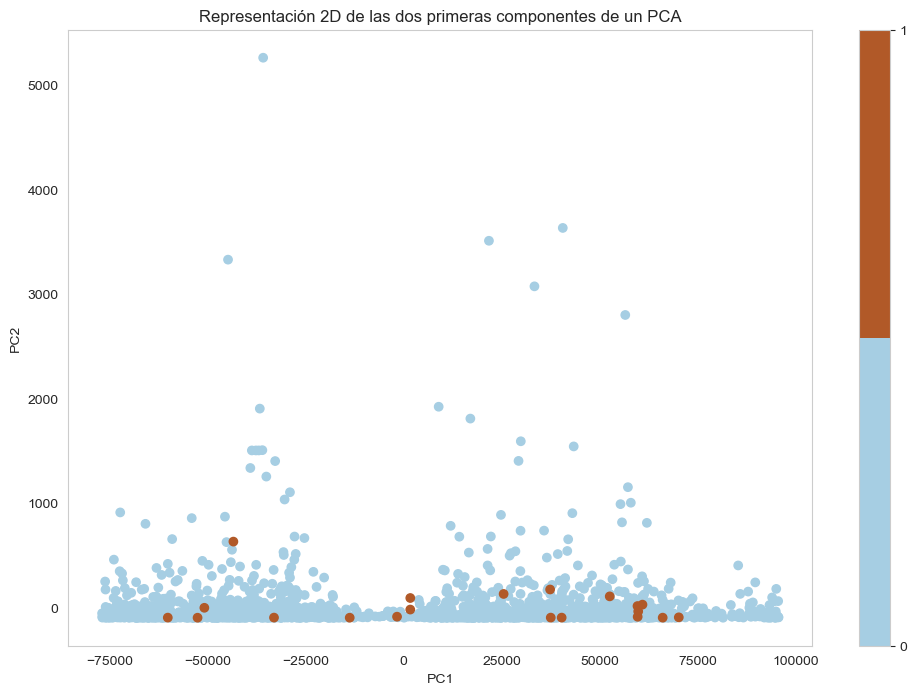

In [39]:
plt.figure(figsize=(12,8))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y_plt, cmap=plt.cm.get_cmap("Paired", 2))
plt.colorbar(ticks=range(2))
plt.title('Representación 2D de las dos primeras componentes de un PCA')
plt.xlabel('PC1'); _=plt.ylabel('PC2')

# Modelaje

### Ajuste del modelo de detección de anomalías a X

Utilizamos el método Local Outlier Factor (LOF). Este método sólo se fija en los vecinos locales de cada punto por lo que vamos a ajustar el modelo a todos los datos X. Un parámetro que se puede ir cambiando es el número de vecinos. A menor número más se ajusta el modelo.

In [40]:
clf = LocalOutlierFactor(n_neighbors = 10, # Número de vecinos que se utilizarán para calcular la desviación local de densidades de cada punto.
                         algorithm = 'auto', # Se seleccionará automáticamente el algoritmo más apropiado según los datos de entrada.
                         leaf_size = 30, # Tamaño de las hojas del árbol utilizado en el algoritmo de búsqueda de vecinos más cercanos.
                         metric = 'minkowski', # Métrica utilizada para calcular la distancia entre los puntos.
                         p = 2, # Parámetro de la métrica de Minkowski que controla el orden de la distancia (euclidiana).
                         metric_params = None, 
                         n_jobs = -1, # Número de trabajos paralelos que se utilizarán para el cálculo.
                         novelty = False # El modelo se ajustará como un modelo de detección de anomalías.
                         )

In [41]:
clf.fit(X)

LocalOutlierFactor(n_jobs=-1, n_neighbors=10)

### Detección de anomalías

Después de ajustar el modelo Local Outlier Factor (LOF) a los datos, este fragmento de código calcula los factores de anomalía para cada punto en el conjunto de datos. Los valores más negativos indican una mayor anormalidad, es decir, son más propensos a ser anomalías.

In [42]:
factores_LOF = clf.negative_outlier_factor_
factores_LOF

array([-1.19618609, -1.15222336, -1.61787169, ..., -1.32806678,
       -1.24067801, -1.75327498])

El modelo nos proporciona lo que se denominan factores de anomalías negativos. Cuanto más alto es este valor, más normal es el punto. Es decir, si queremos quedarnos con el 2 % de puntos más anómalos, debemos quedarnos con el 2 % de valores más bajo. Ponemos el umbral en un 2 % para tener margen.

In [43]:
# Clasificamos los puntos de acuerdo con sus factores de anomalía calculados por el modelo LOF. 
y_pred = factores_LOF.copy()
y_pred[factores_LOF >= np.percentile(factores_LOF,2.)] = 0
y_pred[factores_LOF < np.percentile(factores_LOF,2.)] = 1

En resumen, este código clasifica los puntos como anomalías (1) o no anomalías (0) basándose en sus factores de anomalía calculados por el modelo LOF, utilizando el percentil 2 como umbral para distinguir entre anomalías y no anomalías. Los puntos con factores de anomalía más bajos que el percentil 2 se consideran anomalías, mientras que los puntos con factores de anomalía iguales o superiores al percentil 2 se consideran no anomalías.

La AUC de la ROC es de: 0.67
La F1 es de: 0.06

Accuracy	0.98
Sensitividad	0.358
Precisión	0.031


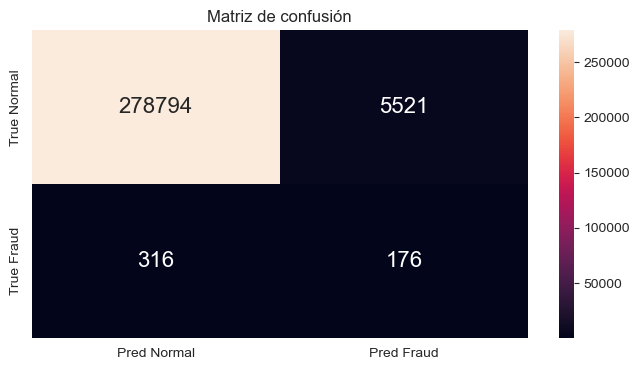

In [44]:
roc_auc = metrics.roc_auc_score(Y, y_pred)
metrica_f1 = metrics.f1_score(Y, y_pred)
matriz_confusion = metrics.confusion_matrix(Y, y_pred)

print(u'La AUC de la ROC es de: {}'.format(round(roc_auc,2)))
print(u'La F1 es de: {}'.format(round(metrica_f1,2)))

df_matriz_confusion = pd.DataFrame(matriz_confusion, 
                     ['True Normal','True Fraud'],
                     ['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
plt.title(u'Matriz de confusión')
_ = sns.heatmap(df_matriz_confusion, annot=True, annot_kws={"size": 16}, fmt='g')

print("\nAccuracy\t{}".format(round(metrics.accuracy_score(Y, y_pred),3)))  
print("Sensitividad\t{}".format(round(metrics.recall_score(Y, y_pred),3)))
print(u"Precisión\t{}".format(round(metrics.precision_score(Y, y_pred),3)))   

Como vemos, con un dos por ciento de la muestra detectada como fraude, detectamos más del 50 % de las transacciones fraudulentas.

### Representación de las probabilidades

Normalizo los factores al rango (0,1) para obtener una estimación de probabilidades:

In [45]:
y_pred_normalised = (factores_LOF - np.min(factores_LOF)) / (np.max(factores_LOF) - np.min(factores_LOF))
y_pred_normalised_pos = y_pred_normalised[np.where(Y == 1)]
y_pred_normalised_neg = y_pred_normalised[np.where(Y == 0)]

/var/folders/pr/98xsblmx0js081jf_gv6xm5m0000gn/T/ipykernel_58991/661629558.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_pred_normalised_pos, norm_hist=True, bins=30, hist=False, label='', kde_kws={"color": "r", "lw": 5})
/var/folders/pr/98xsblmx0js081jf_gv6xm5m0000gn/T/ipykernel_58991/661629558.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please s

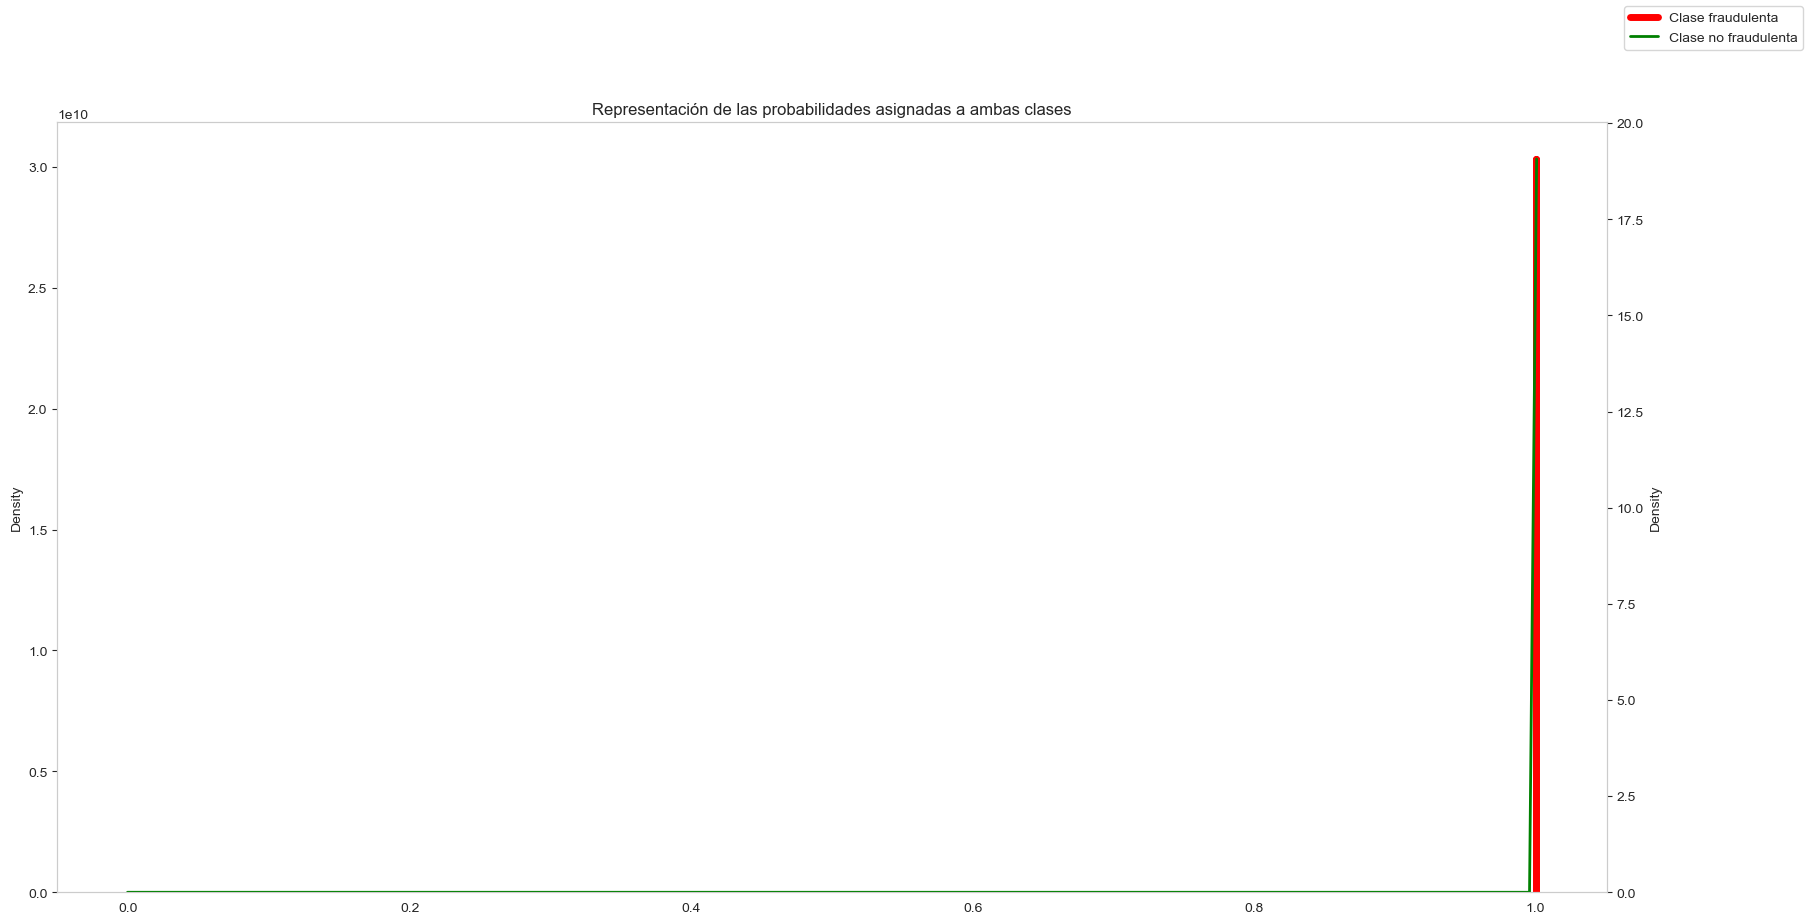

In [46]:
fig = plt.figure(figsize=(20,10))
ax = sns.distplot(y_pred_normalised_pos, norm_hist=True, bins=30, hist=False, label='', kde_kws={"color": "r", "lw": 5})  
ax2 = ax.twinx()
sns.distplot(y_pred_normalised_neg, norm_hist=True ,ax=ax2, bins=30, hist=False, label='', kde_kws={"color": "g", "lw": 2}) 
sns.set_style("whitegrid", {'axes.grid' : False})
ax.figure.legend(['Clase fraudulenta', 'Clase no fraudulenta'])
new_style = {'grid': False}
plt.rc('axes', **new_style)
plt.title('Representación de las probabilidades asignadas a ambas clases')
plt.show()

El modelo asigna a la clase fraudulenta valores centrados en el 1 (anómalos). Por otro lado, la clase no fraudulenta tiene muchos valores en 0s y en 1s.

### Representación de la ganancia a no tener modelo

En este punto analizamos qué mejora nos da el modelo. Es decir, que ventaja tiene una empresa usando un modelo de detección de anomalías a no usarlo.

Creamos una matriz donde cada fila contiene dos valores: el valor original de y_pred_normalised y su complemento (1 - x), donde x es el valor original. Esto se hace para tener una representación de las probabilidades asignadas a ambas clases (fraudulenta y no fraudulenta) en cada fila.

In [47]:
y_pred_normalised_1_0 = np.column_stack((y_pred_normalised,list(map(lambda x: 1-x, y_pred_normalised))))
y_pred_normalised_1_0

array([[1.00000000e+00, 9.01656527e-12],
       [1.00000000e+00, 7.66331443e-12],
       [1.00000000e+00, 2.19955165e-11],
       ...,
       [1.00000000e+00, 1.30756517e-11],
       [1.00000000e+00, 1.03859144e-11],
       [1.00000000e+00, 2.61631827e-11]])

Podemos representar la ganancia acumulada que obtenemos entre tener modelo y no tenerlo:

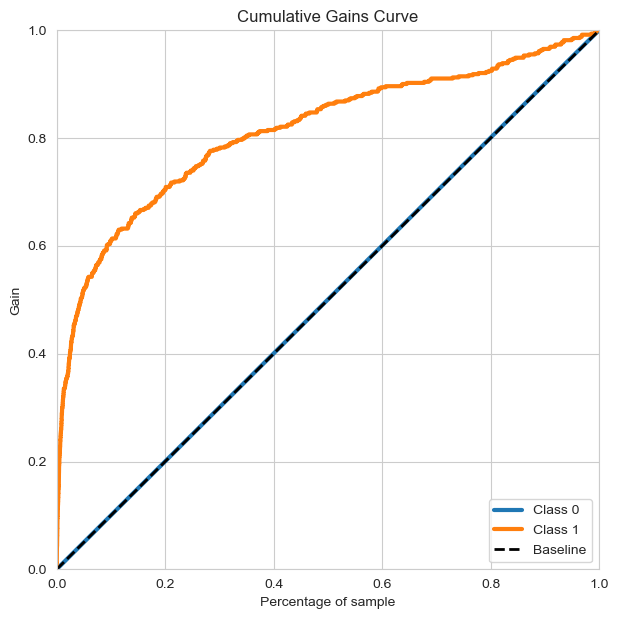

In [48]:
skplt.metrics.plot_cumulative_gain(Y, y_pred_normalised_1_0, figsize=(7,7))
plt.show()

La curva de Lift nos indica para cada porcentaje de las transacciones más probables de ser fraude cuál es la ganancia que obtenemos con el modelo. En este caso, si cogemos al 10 % de más transacciones más probables, mejoramos a una decisión aleatoria en un 1000 % aproximadamente. 

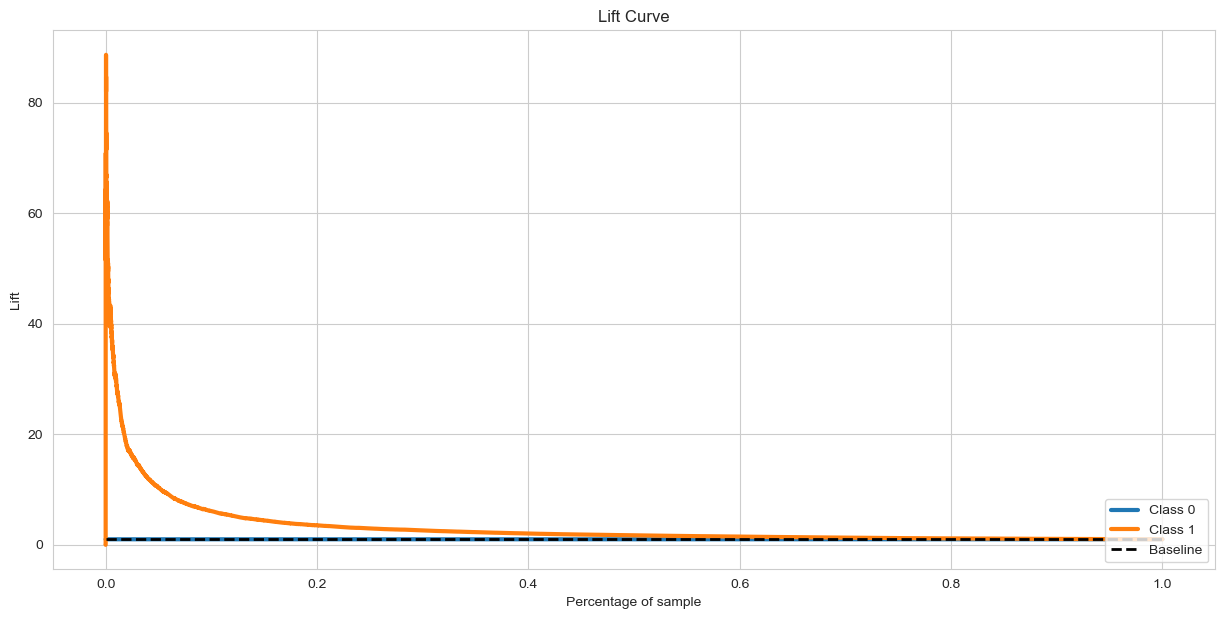

In [49]:
skplt.metrics.plot_lift_curve(Y, y_pred_normalised_1_0, figsize=(15,7))
plt.show()

En este punto, la empresa simplemente auditando un pequeño porcentaje de todas las transacciones totales, daría con la mayoría de las transacciones fraudulentas. Esto ahorraría tiempo y esfuerzo por muchos trabajadores, los cuales podrían dedicarse a otras tareas.